In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from graphviz import Source

import time

start_time = time.time()


warnings.filterwarnings('ignore')

df = pd.read_csv('../db/out/wta_s.csv')

In [2]:
df.info()

df_2023 = df[df['date'].str.contains(
    '2023', na=False) | df['date'].str.contains('2022', na=False)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34466 entries, 0 to 34465
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   match_id                     34466 non-null  int64  
 1   date                         34466 non-null  object 
 2   y                            34466 non-null  int64  
 3   win_percentage_vs            34466 non-null  float64
 4   bp_factor_vs                 34466 non-null  float64
 5   first_won_serve_vs           34466 non-null  float64
 6   second_won_serve_vs          34466 non-null  float64
 7   ace_probability_vs           34466 non-null  float64
 8   double_fault_probability_vs  34466 non-null  float64
 9   aceDf_vs                     34466 non-null  float64
 10  rank                         34466 non-null  float64
 11  rank_points                  34466 non-null  float64
 12  elo                          34466 non-null  float64
 13  glicko          

In [4]:
# df_2023.info()

In [5]:
# testp1 = df.filter(regex='_P1_VS$', axis=1)

# testp2 = df.filter(regex='_P2_VS$', axis=1)


# feats = list(zip(testp1.columns, testp2.columns))


# for col_a, col_b in feats:
#     df[col_a[:-6] + '_diff' + '_vs'] = df[col_a] - df[col_b]

# df.drop(testp1.columns, axis=1, inplace=True)

# df.drop(testp2.columns, axis=1, inplace=True)

# non_numeric_columns = df.select_dtypes(['object']).columns

# df = df.drop(non_numeric_columns, axis=1)

# testp1 = df.filter(regex='_P1$', axis=1)

# testp2 = df.filter(regex='_P2$', axis=1)

# feats = list(zip(testp1.columns, testp2.columns))

# for col_a, col_b in feats:
#     df[col_a[:-3] + '_diff'] = df[col_a] - df[col_b]

# df.drop(testp1.columns, axis=1, inplace=True)

# df.drop(testp2.columns, axis=1, inplace=True)

In [3]:
non_numeric_columns = df.select_dtypes(['object']).columns

df_numeric_only = df.drop(non_numeric_columns, axis=1)

df = df_numeric_only

df = df.drop(['match_id'], axis=1)

df = df.fillna(df.median())


# def normalize(dff):
#     result = dff.copy()
#     for feature_name in dff.columns:
#         max_value = dff[feature_name].max()
#         min_value = dff[feature_name].min()
#         result[feature_name] = (
#             dff[feature_name] - min_value) / (max_value - min_value)
#     return result


# df = normalize(df)
# df.info()
df = df.fillna(df.median())

In [4]:
from sklearn.model_selection import train_test_split

Y = pd.DataFrame(df['y'])
df = df.drop(['y'], axis=1)
X = df
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=45, stratify=Y)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test.values)

basic_report = classification_report(y_test, y_pred, output_dict=True)


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.show()

y_pred_proba = result.predict(X_test.values)
fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_basic = metrics.roc_auc_score(y_test, y_pred_proba)

In [8]:
print(basic_report)

{'0': {'precision': 0.5964912280701754, 'recall': 0.6017699115044248, 'f1-score': 0.5991189427312775, 'support': 1695.0}, '1': {'precision': 0.6113989637305699, 'recall': 0.6061643835616438, 'f1-score': 0.6087704213241615, 'support': 1752.0}, 'accuracy': 0.6040034812880766, 'macro avg': {'precision': 0.6039450959003727, 'recall': 0.6039671475330344, 'f1-score': 0.6039446820277194, 'support': 3447.0}, 'weighted avg': {'precision': 0.6040683539410808, 'recall': 0.6040034812880766, 'f1-score': 0.6040244810239183, 'support': 3447.0}}


In [4]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test.values)

basic_report = classification_report(y_test, y_pred, output_dict=True)

basic_report

{'0.0': {'precision': 0.6284403669724771,
  'recall': 0.6466076696165192,
  'f1-score': 0.6373945914510032,
  'support': 1695.0},
 '1.0': {'precision': 0.6482677627715796,
  'recall': 0.6301369863013698,
  'f1-score': 0.6390738060781476,
  'support': 1752.0},
 'accuracy': 0.6382361473745286,
 'macro avg': {'precision': 0.6383540648720283,
  'recall': 0.6383723279589445,
  'f1-score': 0.6382341987645754,
  'support': 3447.0},
 'weighted avg': {'precision': 0.6385179989539183,
  'recall': 0.6382361473745286,
  'f1-score': 0.6382480826104918,
  'support': 3447.0}}

In [5]:
from sklearn.svm import NuSVC

model = NuSVC()

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

basic_report = classification_report(y_test, y_pred, output_dict=True)

basic_report

{'0': {'precision': 0.5748963883955003,
  'recall': 0.5728613569321533,
  'f1-score': 0.5738770685579195,
  'support': 1695.0},
 '1': {'precision': 0.5881683731513083,
  'recall': 0.5901826484018264,
  'f1-score': 0.5891737891737892,
  'support': 1752.0},
 'accuracy': 0.5816652161299681,
 'macro avg': {'precision': 0.5815323807734043,
  'recall': 0.5815220026669898,
  'f1-score': 0.5815254288658543,
  'support': 3447.0},
 'weighted avg': {'precision': 0.5816421143288266,
  'recall': 0.5816652161299681,
  'f1-score': 0.5816519030571954,
  'support': 3447.0}}

In [6]:
from sklearn.tree import ExtraTreeClassifier

model = ExtraTreeClassifier()

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

basic_report = classification_report(y_test, y_pred, output_dict=True)

basic_report

{'0': {'precision': 0.5748963883955003,
  'recall': 0.5728613569321533,
  'f1-score': 0.5738770685579195,
  'support': 1695.0},
 '1': {'precision': 0.5881683731513083,
  'recall': 0.5901826484018264,
  'f1-score': 0.5891737891737892,
  'support': 1752.0},
 'accuracy': 0.5816652161299681,
 'macro avg': {'precision': 0.5815323807734043,
  'recall': 0.5815220026669898,
  'f1-score': 0.5815254288658543,
  'support': 3447.0},
 'weighted avg': {'precision': 0.5816421143288266,
  'recall': 0.5816652161299681,
  'f1-score': 0.5816519030571954,
  'support': 3447.0}}

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Define model
model = DecisionTreeClassifier(max_depth=10, random_state=75)


param_grid = {
    'max_depth': list(range(5, 20, 1)),
    'max_features': ['auto', 'sqrt', 'log2']
}

search = RandomizedSearchCV(model, param_grid, n_iter=15,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=1, verbose=2)

# search = RFE(model, n_features_to_select=5, step=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best Score: 0.6516329355290018
Best Hyperparameters: {'max_features': 'log2', 'max_depth': 5}


              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1695
           1       0.65      0.69      0.67      1752

    accuracy                           0.66      3447
   macro avg       0.66      0.66      0.66      3447
weighted avg       0.66      0.66      0.66      3447



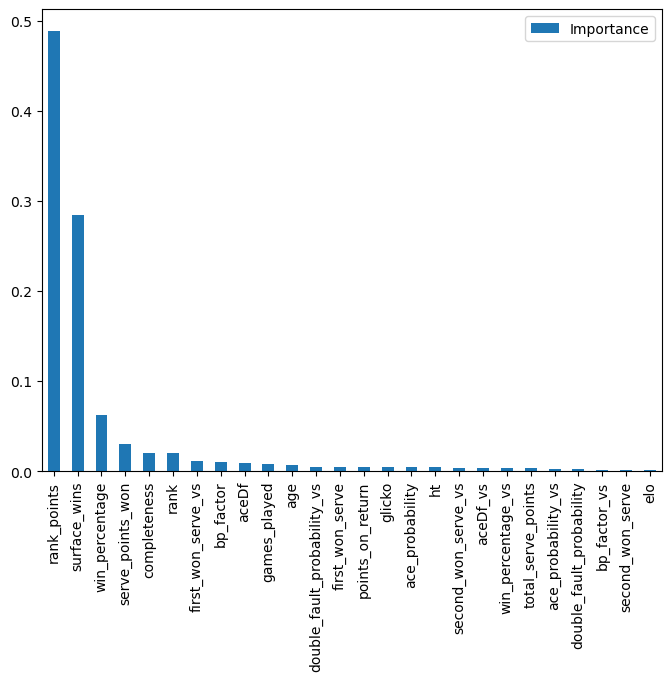

In [10]:
model = DecisionTreeClassifier(
    max_depth=7, max_features='log2', criterion='entropy')


result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


feat_importances = pd.DataFrame(
    model.feature_importances_, index=X_test.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8, 6))
plt.show()

In [11]:
model = DecisionTreeClassifier()


param_grid = {
    'max_depth': list(range(5, 20, 1)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

search = RandomizedSearchCV(model, param_grid, n_iter=25,
                            cv=5, scoring='accuracy', n_jobs=-1, random_state=45, verbose=2)

# search = RFE(model, n_features_to_select=5, step=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.show()

best_random = result.best_estimator_
y_pred_test = best_random.predict(X_test)
print(classification_report(y_test, y_pred_test))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
# plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
# plt.plot(fpr_basic, tpr_basic, label="Basic, auc=" +
#          str(auc_basic), color='blue')
# plt.legend(loc=4)
# plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Score: 0.6620135813321335
Best Hyperparameters: {'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1695
           1       0.66      0.68      0.67      1752

    accuracy                           0.66      3447
   macro avg       0.66      0.66      0.66      3447
weighted avg       0.66      0.66      0.66      3447



Optimal number of features : 3
                             Rank
surface_wins                    1
rank                            1
rank_points                     1
games_played                    2
win_percentage                  3
serve_points_won                4
completeness                    5
first_won_serve                 6
double_fault_probability        7
ace_probability                 8
age                             9
bp_factor                      10
second_won_serve_vs            11
aceDf                          12
bp_factor_vs                   13
second_won_serve               14
elo                            15
first_won_serve_vs             16
total_serve_points             17
points_on_return               18
aceDf_vs                       19
double_fault_probability_vs    20
ht                             21
glicko                         22
ace_probability_vs             23
win_percentage_vs              24
['rank', 'rank_points', 'surface_wins']
           

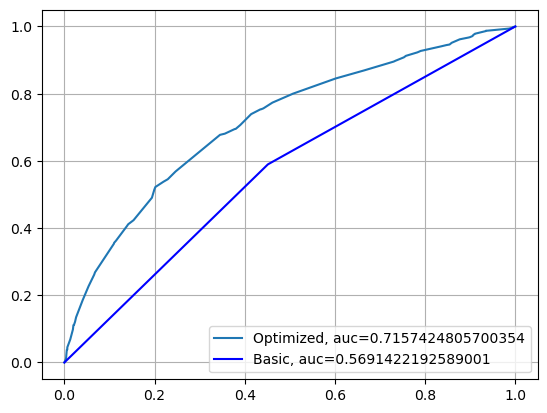

In [12]:
# Decision tree with RFECV
from sklearn.tree import export_graphviz
from graphviz import Source

model = DecisionTreeClassifier(
    max_depth=7, max_features='log2', criterion='entropy', random_state=45)

cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

selected_features = ranks[ranks['Rank'] == 1].index.values.tolist()


# print(rfecv.feature_names_in_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

ranks_1 = ranks[ranks['Rank'] == 1]

# selected_features = ranks[ranks['Rank'] == 1].index.values.tolist()

export_graphviz(rfecv.estimator_, out_file='tree.dot', feature_names=ranks_1.index.values,
                class_names=['0', '1'], rounded=True, filled=True)


print(selected_features)


# print(ranks_1)

# print(ranks.sort_values(by='Rank', ascending=True))

# selected_features = ranks_1

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
# plt.style.use('ggplot')
# plt.figure(figsize=(12, 6))
# plt.xlabel('Number of features selected')
# plt.ylabel('Cross validation score (nb of correct classifications)')
# plt.plot(range(1, len(rfecv.cv_results_[
#          "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
# plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show()


print(classification_report(y_test, y_pred))


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix


# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.grid(False)
# plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="Optimized, auc="+str(auc))
plt.plot(fpr_basic, tpr_basic, label="Basic, auc=" +
         str(auc_basic), color='blue')
plt.legend(loc=4)
plt.show()

In [13]:
# X = df[selected_features]
# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.1, random_state=45, stratify=Y)

In [14]:
# model = DecisionTreeClassifier(
#     max_depth=7, max_features='log2', criterion='entropy')


# result = model.fit(X_train, y_train)
# y_pred = model.predict(X_test)


# print(classification_report(y_test, y_pred))


# plt.grid(True)
# plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
# plt.plot(fpr_basic, tpr_basic, label="Basic, auc=" +
#          str(auc_basic), color='blue')
# plt.legend(loc=4)
# plt.show()

# export_graphviz(model, out_file='tree.dot', feature_names=X.columns,
#                 class_names=['0', '1'], rounded=True, filled=True)


# feat_importances = pd.DataFrame(
#     model.feature_importances_, index=X_test.columns, columns=["Importance"])
# feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# feat_importances.plot(kind='bar', figsize=(8, 6))
# plt.show()


# y_pred_proba = result.predict(X_test)
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plt.grid(True)
# plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
# plt.plot(fpr_basic, tpr_basic, label="Basic, auc=" +
#          str(auc_basic), color='blue')
# plt.legend(loc=4)
# plt.show()

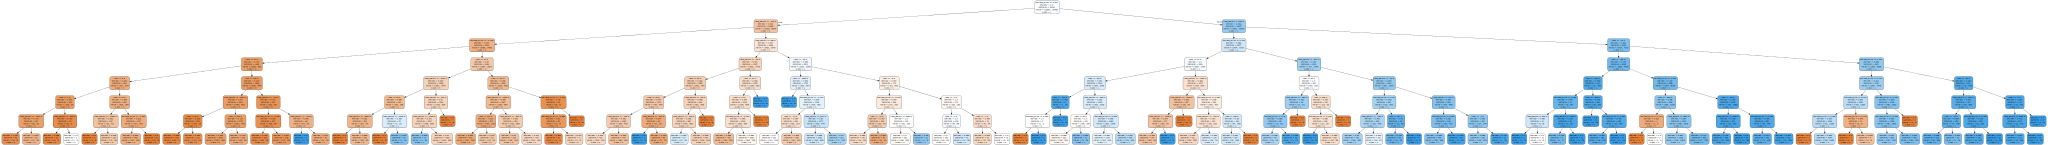

In [15]:
from graphviz import Source
Source.from_file("tree.dot")

In [16]:
import json

filename = 'results.json'

final_results = {
    "report_basic": basic_report,
    # "fpr_basic": fpr_basic.tolist(),
    # "tpr_basic": tpr_basic.tolist(),
    "auc_basic": float(auc_basic),
    "report_optimized": classification_report(y_test, y_pred, output_dict=True),
    # "fpr_optimized": fpr.tolist(),
    # "tpr_optimized": tpr.tolist(),
    "auc_optimied": float(auc),
    "selected_features": selected_features,  # convert Index object to list
    "time": time.time() - start_time
}

try:
    with open(filename, 'r') as file:
        data = json.load(file)
except FileNotFoundError:
    data = {}

data['DecisionTree'] = final_results

try:
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)
except json.JSONDecodeError as e:
    print(f"Error: {e}")


data['DecisionTree'] = (final_results)


with open('results.json', 'w') as file:
    json.dump(data, file, indent=4)